Epoch 1, Train Loss: 0.2271, Val Loss: 0.1013, Train Acc: 0.9316, Val Acc: 0.9704
Epoch 2, Train Loss: 0.0907, Val Loss: 0.1019, Train Acc: 0.9720, Val Acc: 0.9724
Epoch 3, Train Loss: 0.0724, Val Loss: 0.0879, Train Acc: 0.9776, Val Acc: 0.9748
Epoch 4, Train Loss: 0.0613, Val Loss: 0.0948, Train Acc: 0.9809, Val Acc: 0.9724
Epoch 5, Train Loss: 0.0560, Val Loss: 0.1026, Train Acc: 0.9820, Val Acc: 0.9731
Epoch 6, Train Loss: 0.0474, Val Loss: 0.1117, Train Acc: 0.9848, Val Acc: 0.9718
Early stopping at epoch 6


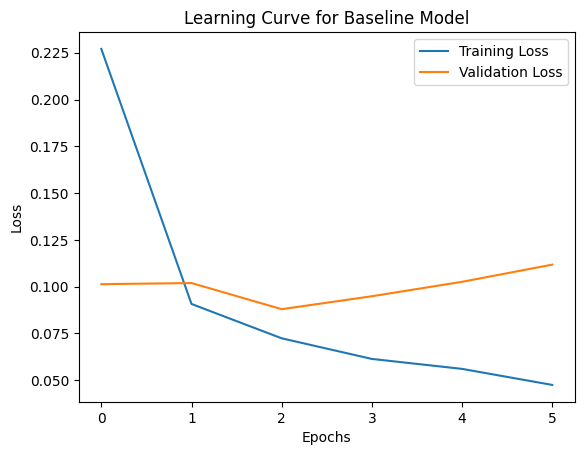

Test Loss: 0.0905, Test Accuracy: 0.9755


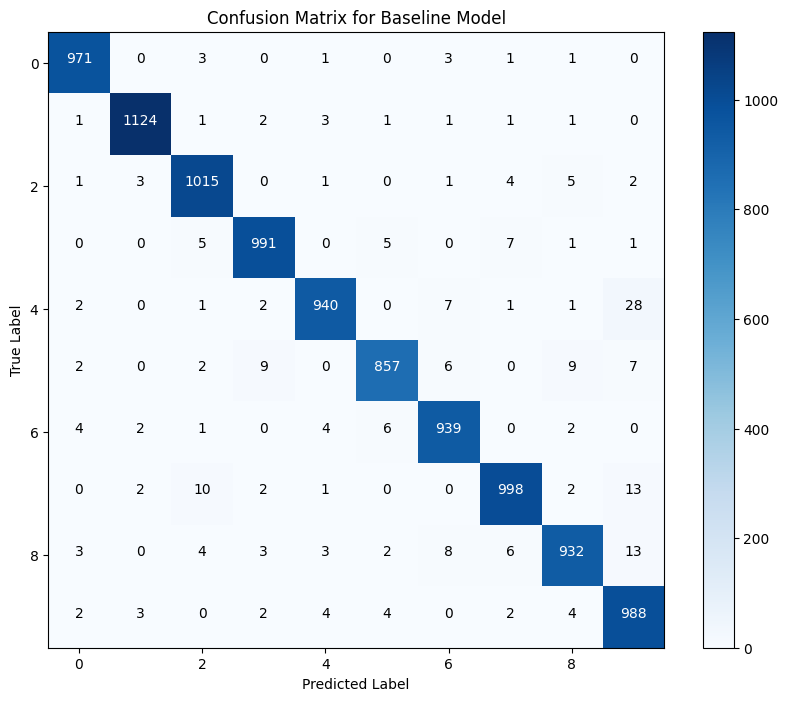

'\nThe model’s learning curves show that it learns well at first, with both training and validation losses decreasing.\nHowever, after about 5 epochs, the validation loss starts to rise, suggesting that the model might be overfitting,\nlearning specific details in the training data that don’t generalize to new data. Stopping training early at 9 epochs\nhelped prevent further overfitting. The confusion matrix reveals that the model mostly predicts digits correctly but\nmakes a few mistakes, often confusing similar-looking numbers like 3 and 5 or 4 and 9. This makes sense because these\npairs share similar shapes. The model’s filters, or "kernels," in the first layer seem to detect simple edges and lines,\nwhile the next layer’s filters combine these basic shapes into more complex patterns. These patterns help the model\nrecognize specific features of each digit, allowing it to distinguish between different numbers reasonably well.\n'

In [5]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Split training data into train and validation
train_data, val_data = random_split(train_data, [50000, 10000])
train_loader = DataLoader(train_data, batch_size=50, shuffle=True)
val_loader = DataLoader(val_data, batch_size=50, shuffle=False)
test_loader = DataLoader(test_data, batch_size=50, shuffle=False)

# Define the baseline CNN model
class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(6, 3, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(3 * 28 * 28, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x  # Directly return logits, CrossEntropyLoss will apply softmax

# Initialize model, optimizer, and loss function
model = BaselineCNN()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)
criterion = nn.CrossEntropyLoss()

# Training function
def train(model, loader):
    model.train()
    total_loss, correct = 0, 0
    for batch, labels in loader:
        optimizer.zero_grad()
        output = model(batch)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * batch.size(0)
        correct += (output.argmax(1) == labels).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

# Evaluation function
def evaluate(model, loader):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for batch, labels in loader:
            output = model(batch)
            loss = criterion(output, labels)
            total_loss += loss.item() * batch.size(0)
            correct += (output.argmax(1) == labels).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

# Train the model with early stopping
epochs = 20
train_losses, val_losses = [], []
best_val_loss = float('inf')
patience, trigger_times = 3, 0  # For early stopping
for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader)
    val_loss, val_acc = evaluate(model, val_loader)
    scheduler.step()
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')
    
    # Early stopping condition
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0  # Reset trigger on improvement
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Plot learning curves
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curve for Baseline Model')
plt.show()

# Evaluate on test set and display confusion matrix
test_loss, test_acc = evaluate(model, test_loader)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

# Confusion matrix
all_preds = []
all_labels = []
with torch.no_grad():
    for batch, labels in test_loader:
        output = model(batch)
        preds = output.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.title("Confusion Matrix for Baseline Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Add text annotations
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), ha="center", 
                 color="white" if cm[i, j] > thresh else "black")

plt.show()

"""
The models learning curves show that it learns well at first, with both training and validation losses decreasing.
However, after about 5 epochs, the validation loss starts to rise, suggesting that the model might be overfitting,
learning specific details in the training data that dont generalize to new data. Stopping training early at 9 epochs
helped prevent further overfitting. The confusion matrix reveals that the model mostly predicts digits correctly but
makes a few mistakes, often confusing similar-looking numbers like 3 and 5 or 4 and 9. This makes sense because these
pairs share similar shapes. The models filters, or "kernels," in the first layer seem to detect simple edges and lines,
while the next layers filters combine these basic shapes into more complex patterns. These patterns help the model
recognize specific features of each digit, allowing it to distinguish between different numbers reasonably well.
"""

